In [5]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

N_SPLITS = 6

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

model_df = pd.read_csv('../../../csv/vdi_entailment_scores_chunk_size_512_all_chunks_bart_large_with_manual.csv')
model_df = model_df.sort_values(by=['company', 'year'])

In [6]:
x_columns = [f"score_q{i}" for i in range (1, 70)]

X = model_df.loc[:, x_columns].to_numpy()
y = model_df.loc[:, "vdi_score_unscaled"].to_numpy()

In [7]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

Fold 1 - MSE: 287.7647
Fold 2 - MSE: 13.1633
Fold 3 - MSE: 246.4587
Fold 4 - MSE: 267.4423
Fold 5 - MSE: 45.7823
Fold 6 - MSE: 109.7571
Average MSE: 161.7281


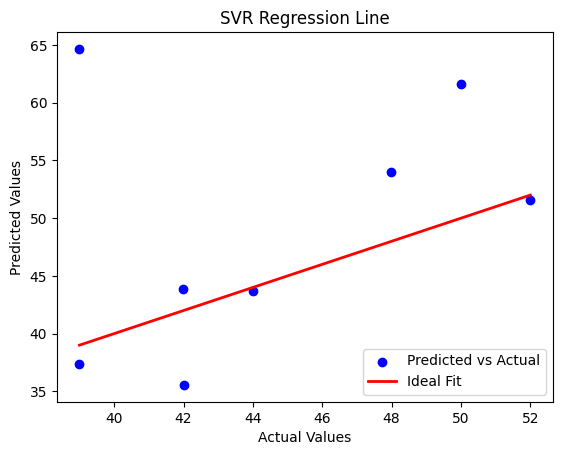

In [8]:
average_mse = 0

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}


for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = x_scaler.fit_transform(X_train)
    X_test = x_scaler.transform(X_test)
    y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
    y_test = y_scaler.transform(y_test.reshape(-1, 1)).reshape(-1)

    regressor = GradientBoostingRegressor(**params)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)
    y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)

    mse = mean_squared_error(y_test, y_pred)
    print(f"Fold {i+1} - MSE: {mse:.4f}")

    average_mse += (mse/N_SPLITS)

import matplotlib.pyplot as plt

print(f"Average MSE: {average_mse:.4f}")

# Plot the regression line
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('SVR Regression Line')
plt.legend()
plt.show()